### 2023年度，確率ロボティクス課題
ロボットのための推定や行動決定アルゴリズムについてのシミュレーション

動作環境
- Ubuntu 22.04 LTS
- Python 3.10.12

参考書籍：「つくりながら学ぶ！深層強化学習」，著者：株式会社電通国際情報サービス 小川雄太郎，出版社：マイナビ出版

アルゴリズムの概要


In [181]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 迷路の描画を行う

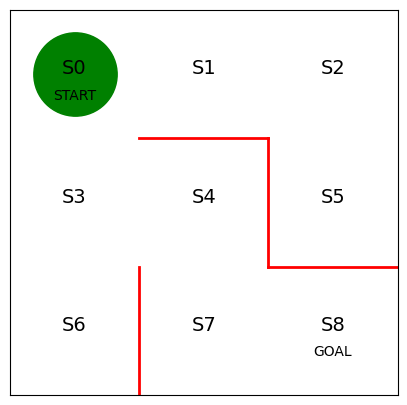

In [182]:
# 図の大きさと図の変数名
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字（S0~S8）
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲と目盛り削除
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# S0に緑色の丸を描画
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

迷路内を緑色で示されたエージェントがランダムに移動してゴールを目指す処理と移動する様子をアニメーションで可視化する処理

In [183]:
# 初期の方策を決定するパラメータtheta_0を設定

# 表形式表現：行は状態s（S0〜S8）を，列は行動a（↑，→，↓，←）を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],         # s0
                    [np.nan, 1, np.nan, 1],         # s1
                    [np.nan, np.nan, 1, 1],         # s2
                    [1, 1, 1, np.nan],              # s3
                    [np.nan, np.nan, 1, 1],         # s4
                    [1, np.nan, np.nan, np.nan],    # s5
                    [1, np.nan, np.nan, np.nan],    # s6
                    [1, 1, np.nan, np.nan],         # s7
                    ])                              # s8はゴールなので方策なし

In [184]:
# 方策パラメータtheta_0をランダム方策piに変換する関数

def simple_convert_info_pi_from_theta(theta):
    [m, n] = theta.shape    #thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :]) # 割合の計算
        
    pi = np.nan_to_num(pi)  #nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_info_pi_from_theta(theta_0)
# 初期の方策pi_0を表示
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [185]:
# 初期の行動価値関数Q

[a, b] = theta_0.shape  # 行と列の数をa,bに格納
Q = np.random.rand(a, b) * theta_0 * 0.1
# theta_0を掛けることで，生成した乱数のうち壁方向に対応するものをnp.nanにする
# 初期のQ値を小さくするため0.1を掛ける（描画しやすく）

In [186]:
# ε-greedy法


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]   # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next

In [187]:
# Q学習による行動価値関数Qの更新

def Q_learning(s, a, r, s_next, Q, eta, gamma):

    if s_next == 8: #ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])

    return Q

In [188]:
# Q学習で迷路を解く関数の定義，状態と行動の履歴および更新したQを出力

def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0   #スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  #初期の行動
    s_a_history = [[0, np.nan]] # エージェントの移動を記録するリスト

    while (1):
        a = a_next  #行動の更新

        s_a_history[-1][1] = a
        # 現在の状態（一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の状態を格納

        s_a_history.append([s_next, np.nan])
        # 次の状態を代入．行動はまだわからないのでnan

        # 報酬を与え，次の行動を求める
        if s_next == 8:
            r = 1   # ゴールに着いたら報酬を与える
            a_next = np.nan
        else :
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動a_nextを求める

        # 価値観数を更新
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 終了判定
        if s_next == 8: # ゴール地点なら終了
            break
        else:
            s = s_next

    return [s_a_history, Q]


In [189]:
# Q学習で迷路を解く

eta = 0.1   # 学習率
gamma = 0.9 # 時間割引率
epsilon = 0.5   # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)    # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

V = []  # エピソードごとの状態価値を格納する
V.append(np.nanmax(Q, axis=1))  # 状態ごとに行動価値の最大値を求める

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード：" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Q学習で迷路を解き，移動した履歴と更新したQを求める
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)    # 状態ごとに行動価値の最大値を求める
    print(np.sum(np.abs(new_v- v))) # 状態価値関数の変化を出力
    v = new_v
    V.append(v) # このエピソード終了時の状態価値関数を追加

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 100エピソード繰り返す
    episode += 1
    if episode > 100:
        break

エピソード：1
0.25671801541023564
迷路を解くのにかかったステップ数は332です
エピソード：2
0.0927395807905039
迷路を解くのにかかったステップ数は6です
エピソード：3
0.09241643099897043
迷路を解くのにかかったステップ数は4です
エピソード：4
0.09139226830743985
迷路を解くのにかかったステップ数は4です
エピソード：5
0.09047735457010933
迷路を解くのにかかったステップ数は4です
エピソード：6
0.08955745605132395
迷路を解くのにかかったステップ数は4です
エピソード：7
0.08862176002786037
迷路を解くのにかかったステップ数は4です
エピソード：8
0.08765859838079068
迷路を解くのにかかったステップ数は4です
エピソード：9
0.08665654994765662
迷路を解くのにかかったステップ数は4です
エピソード：10
0.08560519700688848
迷路を解くのにかかったステップ数は4です
エピソード：11
0.08449561260329397
迷路を解くのにかかったステップ数は4です
エピソード：12
0.08332064116811
迷路を解くのにかかったステップ数は4です
エピソード：13
0.08207502300461665
迷路を解くのにかかったステップ数は4です
エピソード：14
0.08075540333459105
迷路を解くのにかかったステップ数は4です
エピソード：15
0.07936025841927836
迷路を解くのにかかったステップ数は4です
エピソード：16
0.0778897645143549
迷路を解くのにかかったステップ数は4です
エピソード：17
0.0763456298643233
迷路を解くのにかかったステップ数は4です
エピソード：18
0.07473090539458963
迷路を解くのにかかったステップ数は4です
エピソード：19
0.07304978605488154
迷路を解くのにかかったステップ数は4です
エピソード：20
0.0713074117663667
迷路を解くのにかかったステップ数は4です
エピソード：21
0.069

In [190]:
# 状態価値の変化を可視化
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm  # color map


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    # 各マスに状態価値の大きさに基づく色付きの四角を描画
    line, = ax.plot([0.5], [2.5], marker="s", color=cm.jet(V[i][0]), markersize=85) # S0
    line, = ax.plot([1.5], [2.5], marker="s", color=cm.jet(V[i][1]), markersize=85) # S1
    line, = ax.plot([2.5], [2.5], marker="s", color=cm.jet(V[i][2]), markersize=85) # S2
    line, = ax.plot([0.5], [1.5], marker="s", color=cm.jet(V[i][3]), markersize=85) # S3
    line, = ax.plot([1.5], [1.5], marker="s", color=cm.jet(V[i][4]), markersize=85) # S4
    line, = ax.plot([2.5], [1.5], marker="s", color=cm.jet(V[i][5]), markersize=85) # S5
    line, = ax.plot([0.5], [0.5], marker="s", color=cm.jet(V[i][6]), markersize=85) # S6
    line, = ax.plot([1.5], [0.5], marker="s", color=cm.jet(V[i][7]), markersize=85) # S7
    line, = ax.plot([2.5], [0.5], marker="s", color=cm.jet(1.0),     markersize=85) # S8

    return (line,)

# 初期化関数とフレームごとの描画関数を用いてアニメーションを作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

display(HTML(anim.to_jshtml()))